In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## 学習

In [3]:
df = pd.read_csv('train.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,52,services,married,secondary,no,108,yes,no,unknown,15,may,543,12,-1,0,unknown,no
1,35,admin.,married,unknown,no,1055,no,no,cellular,2,mar,59,2,-1,0,unknown,no
2,37,blue-collar,married,secondary,no,32,yes,no,unknown,20,may,146,2,-1,0,unknown,no
3,57,unemployed,married,primary,no,2743,no,no,cellular,29,jan,89,1,-1,0,unknown,no
4,42,self-employed,married,tertiary,no,6383,no,no,cellular,27,aug,111,5,-1,0,unknown,no


## データ確認
参考URL：https://ohke.hateblo.jp/entry/2017/08/04/230000

In [4]:
df['y'].value_counts()

no     35952
yes     4737
Name: y, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d1d4ac8>,
      dtype=object)

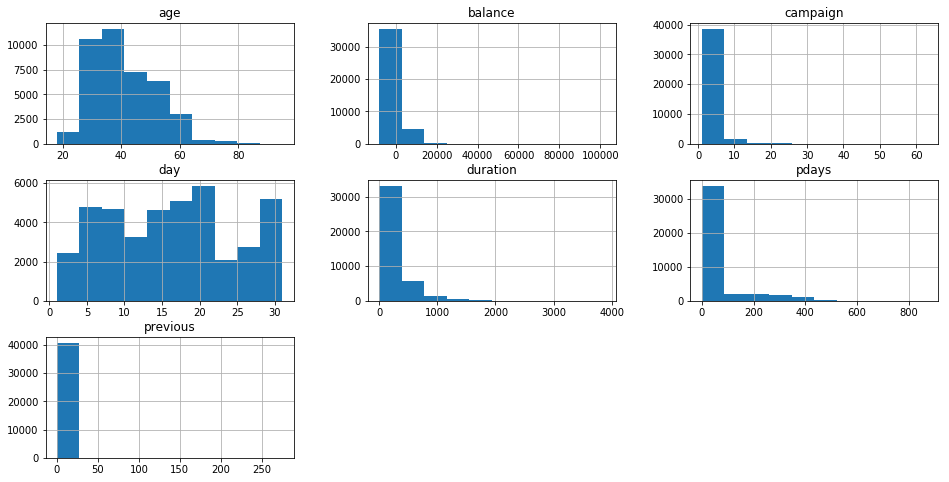

In [5]:
df.hist(figsize=(16,8))

In [6]:
# カテゴリ系の特徴量に含まれる値を確認
for col in df.columns:
    if not isinstance(df[col][0],str):
        continue
    print('({})'.format(col))
    print('{}'.format(np.unique(df[col].values)))

(job)
['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
(marital)
['divorced' 'married' 'single']
(education)
['primary' 'secondary' 'tertiary' 'unknown']
(default)
['no' 'yes']
(housing)
['no' 'yes']
(loan)
['no' 'yes']
(contact)
['cellular' 'telephone' 'unknown']
(month)
['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
(poutcome)
['failure' 'other' 'success' 'unknown']
(y)
['no' 'yes']


In [23]:
def create_feature_df(input_df):
    # 各特徴量の相関係数を可視化
    features_df = pd.DataFrame()

    # 目的変数
    features_df['y'] = input_df['y'].apply(lambda s : 1 if s == 'yes' else 0)

    # 連続値
    features_df['age'] = input_df['age']
    features_df['balance'] = input_df['balance']
    features_df['day'] = input_df['day']
    features_df['duration'] = input_df['duration']
    features_df['campaign'] = input_df['campaign']
    features_df['pdays'] = input_df['pdays']
    features_df['previous'] = input_df['previous']

    # ２値
    features_df['default'] = input_df['default'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['housing'] = input_df['housing'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['loan'] = input_df['loan'].apply(lambda s : 1 if s=='yes' else 0)

    # カテゴリ
    features_df['job'],_ = pd.factorize(input_df['job'])
    features_df['marital'],_ = pd.factorize(input_df['marital'])
    features_df['education'],_ = pd.factorize(input_df['education'])
    features_df['contact'],_ = pd.factorize(input_df['contact'])
    features_df['month'],_ = pd.factorize(input_df['month'])
    features_df['poutcome'],_ = pd.factorize(input_df['poutcome'])
    
    return features_df

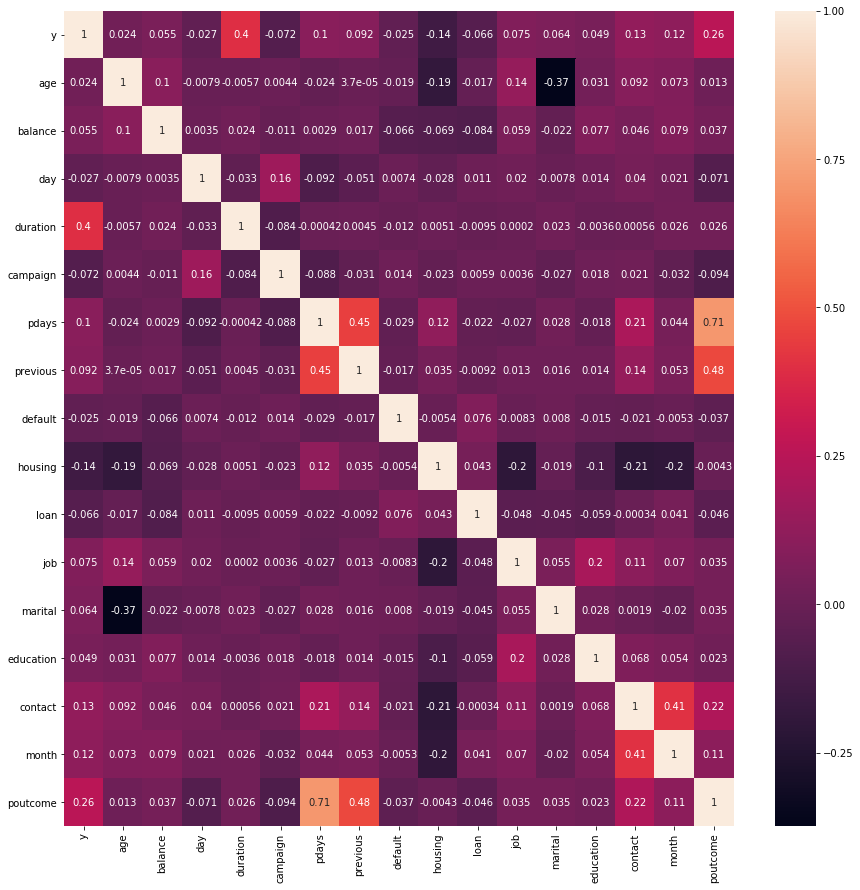

In [24]:
# やってみたけど名義尺度のカテゴリデータに対して相関係数は使えない
import seaborn 
plt.figure(figsize=(15,15))
seaborn.heatmap(create_feature_df(df).corr(), annot=True)

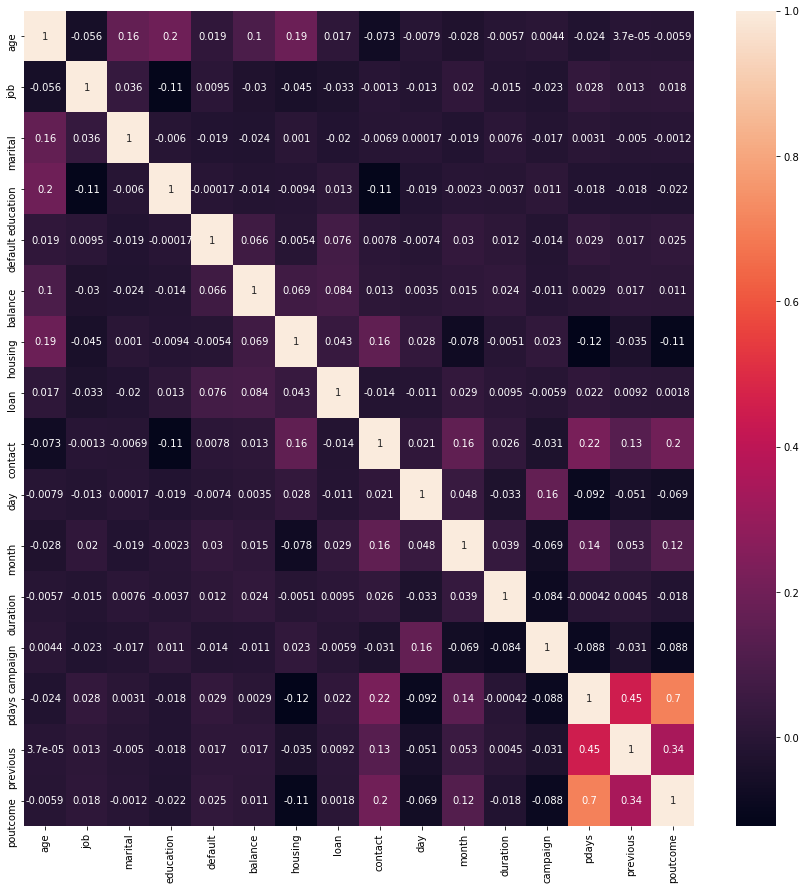

In [59]:
def get_features_df(df):
    df['job'] = pd.get_dummies(df['job'])
    df['housing'] = pd.get_dummies(df['housing'])
    df['default'] = pd.get_dummies(df['default'])
    df['loan'] = pd.get_dummies(df['loan'])
    df['marital'] = pd.get_dummies(df['marital'])
    df['education'] = pd.get_dummies(df['education'])
    df['contact'] = pd.get_dummies(df['contact'])
    df['month'] = pd.get_dummies(df['month'])
    df['poutcome'] = pd.get_dummies(df['poutcome'])
    return df

# やってみたけど名義尺度のカテゴリデータに対して相関係数は使えない
import seaborn 
plt.figure(figsize=(15,15))
seaborn.heatmap(get_features_df(df).corr(), annot=True)

In [58]:
type(pd.get_dummies(df['age']))

pandas.core.frame.DataFrame

In [14]:
def get_features(df):
    # 特徴量として使う連続量
    features_ana = ['age', 'balance','day','duration','campaign','pdays','previous']
    # 連続値として使うカテゴリ値
    features_dig = ['job', 'housing','default','loan','marital','education','contact','month','poutcome']
    X = np.concatenate(
        [df[features_ana].values, pd.get_dummies(df[features_dig]).values],
        axis=1)
    return X

def get_label(df):
    y = df['y'].replace({'yes': 1, 'no': 0}).values
    return y

In [39]:
# 特徴量, ラベルを作成
X = get_features(df)
y = get_label(df)
forest_tarin = create_forest_model_and_fit(df)

/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score: 0.9595222295952223
Confusion matrix:
[[35673   279]
 [ 1368  3369]]
f1 score: 0.804


## モデル構築

In [42]:
def create_forest_model_and_fit(target_df):
    features_df = create_feature_df(target_df)
    X = features_df.drop('y',axis=1).values
    y = get_label(target_df)

    forest = RandomForestClassifier(min_samples_leaf=3,random_state=0)
    forest.fit(X,y)
    # 評価
    print('Train score: {}'.format(forest.score(X, y)))
    #print('Test score: {}'.format(forest.score(X_test, y_test)))
    print('Confusion matrix:\n{}'.format(confusion_matrix(y, forest.predict(X))))
    print('f1 score: {:.3f}'.format(f1_score(y, forest.predict(X))))
    return forest

## テスト

In [34]:
test_df = pd.read_csv('test.csv')

In [36]:
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(forest.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, forest.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, forest.predict(test_X))))
pred_forest =forest.predict(test_X)
print(accuracy_score(test_y,pred_forest))

Test score: 0.8947368421052632
Confusion matrix:
[[3869  101]
 [ 375  177]]
f1 score: 0.427
0.8947368421052632


In [10]:
# accuracy
pred = model.predict(test_X).reshape(-1)
pred = (pred > 0.5).astype(int)

In [13]:
# test ARI (この値を報告してください)
accuracy_score(test_y, pred)

0.8781512605042017

In [44]:
# 外れ値データを外したCSVファイルでやってみる
dropped_train_df = pd.read_csv('dropped_outliers_train.csv')
# 特徴量, ラベルを作成
X = get_features(dropped_train_df)
y = get_label(dropped_train_df)
forest_dropped = create_forest_model_and_fit(dropped_train_df)

# テスト
test_df = pd.read_csv('test.csv')
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(forest_dropped.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, forest_dropped.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, forest_dropped.predict(test_X))))
pred_forest =forest_dropped.predict(test_X)
print(accuracy_score(test_y,pred_forest))

/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score: 0.9601199842643587
Confusion matrix:
[[35661   277]
 [ 1345  3389]]
f1 score: 0.807
Test score: 0.8892083149049094
Confusion matrix:
[[3842  128]
 [ 373  179]]
f1 score: 0.417
0.8892083149049094


In [54]:
# 相関係数がプラスの特徴量だけでやってみる
train_df = pd.read_csv('train.csv')
# 特徴量, ラベルを作成
feature_df = create_feature_df(train_df)
y = get_label(train_df)
train_plus_df = feature_df.drop('y',axis=1)
train_plus_df = train_plus_df.drop('day',axis=1)
train_plus_df = train_plus_df.drop('campaign',axis=1)
train_plus_df = train_plus_df.drop('default',axis=1)
train_plus_df = train_plus_df.drop('housing',axis=1)
train_plus_df = train_plus_df.drop('loan',axis=1)
forest_plus_feature = RandomForestClassifier(min_samples_leaf=3,random_state=0)
forest_plus_feature.fit(train_plus_df.values,y)
print('Train score: {}'.format(forest_plus_feature.score(train_plus_df.values, y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y, forest_plus_feature.predict(train_plus_df.values))))
print('f1 score: {:.3f}'.format(f1_score(y, forest_plus_feature.predict(train_plus_df.values))))

# テスト
test_df = pd.read_csv('test.csv')
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
test_plus_df = test_df.drop('day',axis=1)
test_plus_df = test_plus_df.drop('campaign',axis=1)
test_plus_df = test_plus_df.drop('default',axis=1)
test_plus_df = test_plus_df.drop('housing',axis=1)
test_plus_df = test_plus_df.drop('loan',axis=1)
print('Test score: {}'.format(forest_plus_feature.score(test_plus_df.values, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, forest_plus_feature.predict(test_plus_df.values))))
print('f1 score: {:.3f}'.format(f1_score(test_y, forest_plus_feature.predict(test_plus_df.valus))))
pred_forest =forest_plus_feature.predict(test_X)
print(accuracy_score(test_y,pred_forest))
train_plus_df.head()


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score: 0.9533043328663766
Confusion matrix:
[[35641   311]
 [ 1589  3148]]
f1 score: 0.768


ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 16 